In [139]:
import pickle
import pandas as pd
import cx_Oracle
# from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import recall_score, roc_curve, confusion_matrix, precision_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:0.4f}'.format)

In [6]:
# df1 = pd.DataFrame({"Annual_Income": [30000, 40000, 50000, 20000, 10000], "Home_Owner":["Yes", "Yes", "No", "Yes", "Yes"], "Age":[40, 50, 30, 35, 30], "Default": ["Yes", "No", "No", "Yes", "Yes"]})
# df1 = df1.drop_duplicates(subset=)
# df1 = df1.fillna()

# df1["Is_HOme_owner"] = np.where(df1["Home_Owner"]=="Yes", 1,0)
# df1["Age_less_than"] = np.where(df1["Age"] <= 40, 1, 0)

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split

# y_train = df1.Default
# X_train = df1.drop(columns=["Default", "Home_Owner", "Age"])

# target = np.where(df1["Default"]=="Yes", 1,0)

# rf = RandomForestClassifier(n_estimators=5, random_state=3)
# rf.fit(X_train, target)


In [2]:
# python version -- 3.9.16
df_new = pd.read_csv("/mnt/predictive_maintainece_dataset.csv")
df_new.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [3]:
# dataset predictive_maintenance_dataset.csv has 124494 records and 12 columns
# The target variable/column is the "failure" column where only 106 records have failure
# The target column has values 0 and 1 for non-failure and failure respectively
# The datset is highly imbalanced 
df_new.shape

(124494, 12)

In [4]:
display(df_new.failure.value_counts())
display(df_new.failure.value_counts(normalize=True))

0    124388
1       106
Name: failure, dtype: int64

0    0.999149
1    0.000851
Name: failure, dtype: float64

<AxesSubplot: >

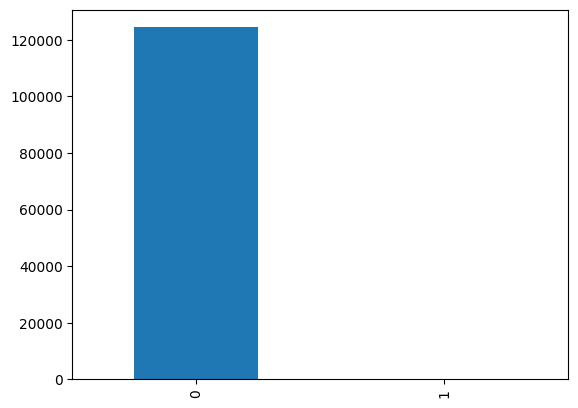

In [14]:
df_new['failure'].value_counts().plot(kind='bar')

<AxesSubplot: xlabel='date'>

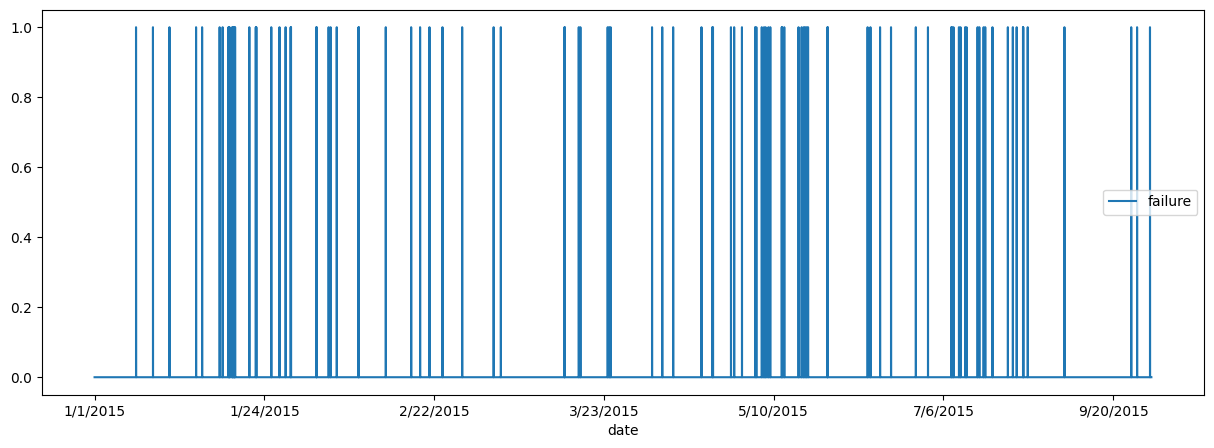

In [9]:
df_new.plot(x='date', y ='failure', kind='line', figsize = (15,5))

In [26]:
display(pd.to_datetime(df_new.date.min()))
display(pd.to_datetime(df_new.date.max()))

Timestamp('2015-01-01 00:00:00')

Timestamp('2015-09-09 00:00:00')

In [18]:
    df_p = df_new[['YM', 'PROVIDERID', 'OUTCOME']].groupby(['YM', 'OUTCOME', ]).PROVIDERID.value_counts()
    df_p = df_p.rename('CNT').reset_index()
    df_p['YM'] = _df_p['YM'].astype(str)

dtype('O')

<AxesSubplot: xlabel='Month'>

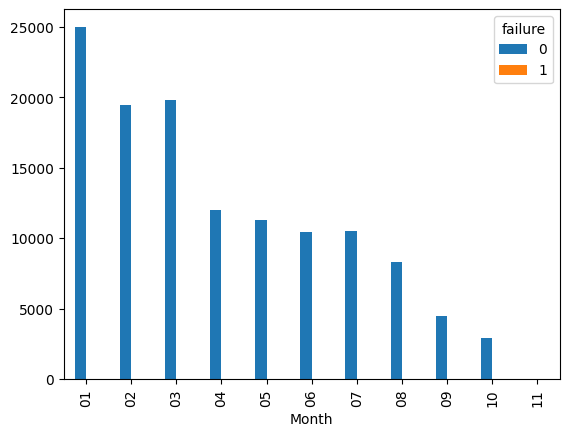

In [55]:
_df_p = df_new[['Month','failure']].groupby(['Month']).failure.value_counts()
_df_p = _df_p.rename('CNT').reset_index()
_df_p['Month'] = _df_p['Month'].astype(str)
_df_p

df_pivot = pd.pivot_table(_df_p, values="CNT", index="Month", columns="failure", aggfunc=np.sum)
df_pivot.plot.bar()

In [29]:
display(df_new.device.value_counts())
display(df_new.device.nunique())

Z1F0QLC1    304
S1F0KYCR    304
S1F0E9EP    304
S1F0EGMT    304
S1F0FGBQ    304
           ... 
W1F1CHZK      5
W1F1CJKT      5
S1F04KSC      4
W1F0WJFT      3
W1F1DA5ÿ      1
Name: device, Length: 1169, dtype: int64

1169

In [56]:
# device is a categorical column
_df_p = df_new[['device','failure']].groupby(['device']).failure.value_counts()
_df_p = _df_p.rename('CNT').reset_index()
_df_p

,device,failure,CNT
0,S1F01085,0,6
1,S1F013BB,0,6
2,S1F0166B,0,6
3,S1F01E6Y,0,48
4,S1F01JE0,0,6
...,...,...,...
1270,Z1F1VQFY,0,124
1271,Z1F1VQFY,1,1
1272,Z1F26YZB,0,84
1273,Z1F282ZV,0,84


In [62]:
df_new[['metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','metric9']].corr()

,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
metric1,1.000000,-0.004254,0.003701,0.001836,-0.003376,-0.001522,0.000151,0.000151,-0.002256
metric2,-0.004254,1.000000,-0.002617,0.146762,-0.013999,-0.026350,0.141366,0.141366,-0.002049
metric3,0.003701,-0.002617,1.000000,0.097452,-0.006697,0.009031,-0.001884,-0.001884,0.369579
metric4,0.001836,0.146762,0.097452,1.000000,-0.009773,0.024870,0.045631,0.045631,0.024892
metric5,-0.003376,-0.013999,-0.006697,-0.009773,1.000000,-0.017049,-0.009384,-0.009384,0.003591
metric6,-0.001522,-0.026350,0.009031,0.024870,-0.017049,1.000000,-0.012207,-0.012207,0.016566
metric7,0.000151,0.141366,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.004684
metric8,0.000151,0.141366,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.004684
metric9,-0.002256,-0.002049,0.369579,0.024892,0.003591,0.016566,0.004684,0.004684,1.000000


In [74]:
df_new[['metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','metric9']].value_counts()

# metric 1, 5,  6 - numerical
# metric 2,3, 4,7,9 - categorical
# metric7 and metric8 are highly correlated

df_new.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000
mean,0.0009,122388103.2421,159.4927,9.9409,1.7411,14.2227,260172.6577,0.2925,0.2925,13.0138
std,0.0292,70459334.2164,2179.6778,185.7481,22.9085,15.9430,99151.0785,7.4369,7.4369,275.6612
min,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,8.0000,0.0000,0.0000,0.0000
25%,0.0000,61284762.0000,0.0000,0.0000,0.0000,8.0000,221452.0000,0.0000,0.0000,0.0000
50%,0.0000,122797388.0000,0.0000,0.0000,0.0000,10.0000,249799.5000,0.0000,0.0000,0.0000
75%,0.0000,183309640.0000,0.0000,0.0000,0.0000,12.0000,310266.0000,0.0000,0.0000,0.0000
max,1.0000,244140480.0000,64968.0000,24929.0000,1666.0000,98.0000,689161.0000,832.0000,832.0000,70000.0000


In [76]:
display(df_new.metric1.nunique()) # 123877
display(df_new.metric2.nunique()) # 560
display(df_new.metric3.nunique()) #48
display(df_new.metric4.nunique()) # 115
display(df_new.metric5.nunique()) #60
display(df_new.metric6.nunique()) # 44838
display(df_new.metric7.nunique()) # 28
display(df_new.metric8.nunique()) #28
display(df_new.metric9.nunique()) # 67

123877

560

48

115

60

44838

28

28

67

In [80]:
df_pivot

failure,0,1
Month,,
01,25008.0000,24.0000
02,19486.0000,14.0000
03,19824.0000,9.0000
04,12003.0000,9.0000
05,11309.0000,21.0000
06,10463.0000,6.0000
07,10515.0000,16.0000
08,8342.0000,4.0000
09,4470.0000,NaN


In [81]:
df_new.isna().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
Month      0
dtype: int64

#### Model buliding

In [189]:
num_cols = ['metric1','metric5','metric6']
cat_cols = ['device','metric2','metric3','metric4','metric5','metric7','metric9']
all_columns = num_cols + cat_cols
target = df_new['failure']

df_train_1 = df_new.copy()
df_train_1['date'] = pd.to_datetime(df_train_1['date'])

df_holdout = df_train_1[df_train_1['date'] >= '07/15/2015']
df_train_1 = df_train_1.drop(df_holdout.index)
print(df_holdout.shape)
print(df_train_1.shape)




(21496, 13)
(102998, 13)


In [156]:
df_holdout.failure.value_counts(normalize=True)

0   0.9993
1   0.0007
Name: failure, dtype: float64

In [157]:
df_train_1.failure.value_counts(normalize=True)

0   0.9991
1   0.0009
Name: failure, dtype: float64

In [190]:
y = df_train_1['failure']
X = df_train_1.drop(['failure', 
                    'date', 
                    ], axis=1)

y_holdout = df_holdout['failure']
X_holdout = df_holdout.drop(['failure', 
                              'date', 
                              ], axis=1)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=3,test_size=0.20, stratify=y)

In [192]:
X_train.shape

(82398, 11)

In [193]:
df_tr = X_train.copy()
df_tr['target'] = y_train.tolist()
df_tr.shape

(82398, 12)

In [194]:
(y_train==0).sum() # 82330
(y_train==1).sum() #68

(y_test==0).sum() # 20577
(y_test==1).sum() #23

y_train = y_train.astype('int')
y_test = y_test.astype('int')
y_holdout = y_holdout.astype('int')



In [195]:
encode_be = ce.BinaryEncoder(cols=cat_cols, return_df=True,)
encode_be.fit(X_train) 
X_train = encode_be.transform(X_train)
X_test = encode_be.transform(X_test)
X_holdout = encode_be.transform(X_holdout)

In [196]:
_num_cols = X_train.select_dtypes(include=['number']).columns
X_train = X_train[_num_cols].fillna(0)
_num_cols = X_test.select_dtypes(include=['number']).columns
X_test = X_test[_num_cols].fillna(0)
_num_cols = X_holdout.select_dtypes(include=['number']).columns
X_holdout = X_holdout[_num_cols].fillna(0)

display(X_train.shape)
display(X_test.shape)
display(X_holdout.shape)

(82398, 54)

(20600, 54)

(21496, 54)

In [214]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y_over))

ImportError: cannot import name 'RandomUnderSampler' from 'imblearn.over_sampling' (/opt/conda/lib/python3.9/site-packages/imblearn/over_sampling/__init__.py)

In [119]:
# !pip install imblearn --user

In [242]:
n_estimators=200
random_state = 3
# max_depth= 4
# min_samples_leaf=6
# min_samples_split=6
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

model = BalancedBaggingClassifier(
        random_state=random_state,
        n_estimators=n_estimators,
#         max_depth= 8,
#         min_samples_leaf=8,
#         min_samples_split=6,
        n_jobs=-1
    )

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(model, X_over, y_over, scoring='f1_micro', cv=cv, n_jobs=-1)

# model = XGBClassifier(random_state=3,n_jobs=-1,
# #       colsample_bytree= 0.9999770728505953,
# #       gamma= 9.178015033367036,
# #       max_delta_step =10.0,
# #       min_child_weight= 13.0,
# #       eta=0.3391640886991351,              
# #       n_estimators= 300,
# #       reg_alpha=50.0,
# #       reg_lambda=0.15721706243187808,
#       seed=0,
#       scale_pos_weight= 7
#   )


# model.fit(X_train,y_train)

In [208]:
np.mean(scores)

0.9998299423018524

In [243]:
model.fit(X_over,y_over)

BalancedBaggingClassifier(n_estimators=200, n_jobs=-1, random_state=3)

In [239]:
predicted_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, predicted_train)
auc = roc_auc_score(y_train, predicted_train)

print(f'Accuracy: {accuracy_train:.3f}')
print(f'AUC: {auc:.3f}')
print(confusion_matrix(y_train, predicted_train))
# print(confusion_matrix(y_test, predicted, normalize='true'))

recall_train = round(recall_score(y_train, predicted_train), 2)
print(f'recall: {recall_train:.3f}')
precision_train = round(precision_score(y_train, predicted_train), 2)
print(f'precision: {precision_train:.2f}')
f1_train = f1_score(y_train, predicted_train)
print(f'F1 score: {f1_train:.3f}' )

Accuracy: 1.000
AUC: 1.000
[[82325     0]
 [    0    73]]
recall: 1.000
precision: 1.00
F1 score: 1.000


In [244]:
predicted_test = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_test)
auc = roc_auc_score(y_test, predicted_test)

print(f'Accuracy: {accuracy:.3f}')
print(f'AUC: {auc:.3f}')
print(confusion_matrix(y_test, predicted_test))

recall = round(recall_score(y_test, predicted_test), 2)
print(f'recall: {recall:.5f}')
precision = round(precision_score(y_test, predicted_test), 2)
print(f'precision: {precision:.5f}')
f1 = f1_score(y_test, predicted_test)
print(f'F1 score: {f1:.6f}' )

Accuracy: 0.998
AUC: 0.500
[[20564    18]
 [   18     0]]
recall: 0.00000
precision: 0.00000
F1 score: 0.000000


In [245]:
predicted_holdout = model.predict(X_holdout)

accuracy = accuracy_score(y_holdout, predicted_holdout)
auc = roc_auc_score(y_holdout, predicted_holdout)

print(f'Accuracy: {accuracy:.3f}')
print(f'AUC: {auc:.3f}')
print(confusion_matrix(y_holdout, predicted_holdout))

recall = round(recall_score(y_holdout, predicted_holdout), 2)
print(f'recall: {recall:.3f}')
precision = round(precision_score(y_holdout, predicted_holdout), 2)
print(f'precision: {precision:.2f}')
f1 = f1_score(y_holdout, predicted_holdout)
print(f'F1 score: {f1:.3f}' )

Accuracy: 0.998
AUC: 0.599
[[21452    29]
 [   12     3]]
recall: 0.200
precision: 0.09
F1 score: 0.128
